In [3]:
%cd drive/MyDrive/seam-carving/

/content/drive/MyDrive/seam-carving


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import cv2
import numpy as np
import os
import errno
from os import path
from glob import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

In [5]:
def calc_img_energy(image):
    image = image.astype('float32')
    energy = np.absolute(cv2.Sobel(image, -1, 1, 0)) + np.absolute(cv2.Sobel(image, -1, 0, 1))
    energy_map = np.sum(energy, axis=2)
    return energy_map

In [6]:
def calc_seam_cost_forward(energy_map):
    shape = m, n = energy_map.shape
    e_map = np.copy(energy_map).astype('float32')
    backtrack = np.zeros(shape, dtype=int)
    for i in range(1, m):
        for j in range(0, n):
            if j == 0:
                min_idx = np.argmin(e_map[i - 1, j:j + 2])
                min_cost = e_map[i - 1, j + min_idx]
                e_map[i, j] += min_cost
                backtrack[i, j] = j + min_idx
            else:
                min_idx = np.argmin(e_map[i - 1, j - 1:j + 2])
                min_cost = e_map[i - 1, j + min_idx - 1]
                e_map[i, j] += min_cost
                backtrack[i, j] = j + min_idx - 1
    return (e_map, backtrack)

In [7]:
def find_min_seam(energy_map_forward, backtrack):
    shape = m, n = energy_map_forward.shape
    seam = np.zeros(m, dtype=int)
    idx = np.argmin(energy_map_forward[-1])
    cost = energy_map_forward[-1][idx]
    seam[-1] = idx
    for i in range(m - 2, -1, -1):
        idx = backtrack[i + 1, idx]
        seam[i] = idx
    return seam, cost

In [8]:
def draw_seam(image, seam):
    rows = np.arange(0, seam.shape[0], 1)
    blue, green, red = cv2.split(image)
    blue[rows, seam] = 0
    green[rows, seam] = 0
    red[rows, seam] = 255
    img_with_seam = np.zeros((blue.shape[0], blue.shape[1], 3))
    img_with_seam[:,:,0] = blue
    img_with_seam[:,:,1] = green
    img_with_seam[:,:,2] = red
    return img_with_seam

In [9]:
def remove_seam(image, seam):
    m, n, _ = image.shape
    out_image = np.zeros((m, n - 1, 3)).astype(dtype=int)
    for i in range(m):
        j = seam[i]
        out_image[i, :, 0] = np.delete(image[i, :, 0], j)
        out_image[i, :, 1] = np.delete(image[i, :, 1], j)
        out_image[i, :, 2] = np.delete(image[i, :, 2], j)
    return out_image

In [10]:
def insert_seam(image, seam):
    m, n, num_channels = image.shape
    out_image = np.zeros((m, n + 1, 3)).astype(dtype=int)
    for i in range(m):
        j = seam[i]
        for ch in range(num_channels):
            if j == 0:
                out_image[i, j, ch] = image[i, j, ch]
                out_image[i, j + 1:, ch] = image[i, j:, ch]
                out_image[i, j + 1, ch] = (int(image[i, j, ch]) + int(image[i, j + 1, ch])) / int(2)
            elif j + 1 == n:
                out_image[i, :j + 1, ch] = image[i, :j + 1, ch]
                out_image[i, j + 1, ch] = int(image[i, j, ch])
            else:
                out_image[i, :j, ch] = image[i, :j, ch]
                out_image[i, j + 1:, ch] = image[i, j:, ch]
                out_image[i, j, ch] = (int(image[i, j - 1, ch]) + int(image[i, j + 1, ch])) / int(2)
    return out_image

In [11]:
def remove_vertical_seam(image):
    img = np.copy(image)
    energy_map = calc_img_energy(img)
    energy_map_forward, backtrack = calc_seam_cost_forward(energy_map)
    (min_seam, cost) = find_min_seam(energy_map_forward, backtrack)
    img = remove_seam(img, min_seam)
    return img, cost

In [12]:
def remove_horizontal_seam(image):
    img = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    energy_map = calc_img_energy(img)
    energy_map_forward, backtrack = calc_seam_cost_forward(energy_map)
    (min_seam, cost) = find_min_seam(energy_map_forward, backtrack)
    img = remove_seam(img, min_seam)
    img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    return img, cost

In [13]:
def calc_seam_cost_forward(energy_map):
    shape = m, n = energy_map.shape
    e_map = np.copy(energy_map).astype('float32')
    backtrack = np.zeros(shape, dtype=int)
    for i in range(1, m):
        for j in range(0, n):
            if j == 0:
                min_idx = np.argmin(e_map[i - 1, j:j + 2])
                min_cost = e_map[i - 1, j + min_idx]
                e_map[i, j] += min_cost
                backtrack[i, j] = j + min_idx
            else:
                min_idx = np.argmin(e_map[i - 1, j - 1:j + 2])
                min_cost = e_map[i - 1, j + min_idx - 1]
                e_map[i, j] += min_cost
                backtrack[i, j] = j + min_idx - 1
    return (e_map, backtrack)

Figure 5 Shape: (466, 700, 3)


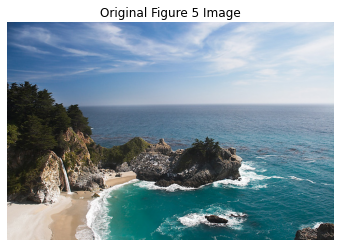

In [14]:
fig5 = cv2.imread('./images/fig5.png', cv2.IMREAD_COLOR)
rgb_fig5 = cv2.cvtColor(fig5, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_fig5); plt.axis("off"); plt.title("Original Figure 5 Image");
print("Figure 5 Shape: %s" % (fig5.shape,))

In [15]:
# Reduce figure 5's width by 1/2 or 350 pixels
# For each pixel to be removed:
# 1-Calculate energy of image
# 2-Calculate seam cost forward
# 3-Find minimum seam
# 4-Draw seam
# 5-Remove seam and traverse pixels left
t0 = time.time()
path = os.path.join(os.getcwd(), 'images/fig5out/')
img = np.copy(fig5)
for c in range(350):
    energy_map = calc_img_energy(img)
    energy_map_forward, backtrack = calc_seam_cost_forward(energy_map)
    (min_seam, cost) = find_min_seam(energy_map_forward, backtrack)
    bgr_img_with_seam = draw_seam(img, min_seam)
    cv2.imwrite('%s%s.png' % (path, c), bgr_img_with_seam)
    img = remove_seam(img, min_seam)
cv2.imwrite('%sfig5_resized.png' % (path), img)
t1 = time.time()
total = t1-t0
print("Total Time: %d" % total)

Total Time: 405


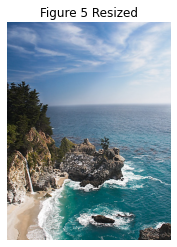

In [16]:
blue, green, red = cv2.split(img)
rgb_img = np.dstack([red, green, blue])
plt.imshow(rgb_img); plt.axis("off"); plt.title("Figure 5 Resized");

Figure 8 Shape: (200, 239, 3)


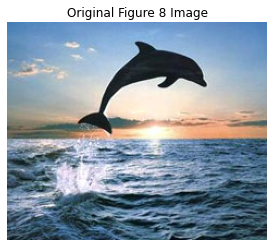

In [17]:
fig8 = cv2.imread('./images/fig8.png', cv2.IMREAD_COLOR)
rgb_fig8 = cv2.cvtColor(fig8, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_fig8); plt.axis("off"); plt.title("Original Figure 8 Image");
print("Figure 8 Shape: %s" % (fig8.shape,))

In [18]:
###### FIGURE 8 ######
# 50% increase, or 120 px showing seams
# Create two lists to track pixels in seams removed (pixels_removed) and subsequent image reductions (pixels_kept).
num_pixels_to_increase = 120 # Increase image by this # of pixels
a = np.arange(0, fig8.shape[1], 1)
b = np.expand_dims(a, axis=0)
pixels_kept = np.repeat(b, fig8.shape[0], axis=0)
pixels_removed = np.zeros((fig8.shape[0],num_pixels_to_increase), dtype=int)
img = np.copy(fig8)

In [19]:
t0 = time.time()
for c in range(num_pixels_to_increase):
    # Find seam to remove
    energy_map = calc_img_energy(img)
    energy_map_forward, backtrack = calc_seam_cost_forward(energy_map)
    (min_seam, cost) = find_min_seam(energy_map_forward, backtrack)
    # Remove minimum seam from ndarray that tracks image reductions and add to list of pixels removed
    rows, cols, _ = img.shape
    mask = np.ones((rows, cols), dtype=np.bool)
    for i in range(0, rows):
        j = min_seam[i]
        mask[i, j] = False
    # Remove seam from image
    pixels_removed[:, c] = pixels_kept[mask == False].reshape((rows,))
    pixels_kept = pixels_kept[mask].reshape((rows, cols - 1))
    img = remove_seam(img, min_seam)

pixels_removed.sort(axis=1)
img = np.copy(fig8)
for c in range(num_pixels_to_increase):
    img = insert_seam(img, pixels_removed[:, c])
    pixels_removed[:, c + 1:] = pixels_removed[:, c + 1:] + 1

t1 = time.time()
total = t1-t0
print("Total Time: %d" % total)

Total Time: 19


Figure 8 Resized Shape: (200, 359, 3)


True

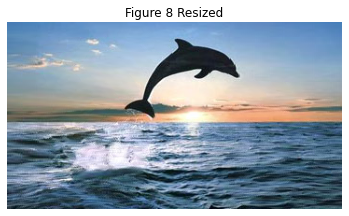

In [20]:
path = os.path.join(os.getcwd(), 'images/fig8out/')
blue, green, red = cv2.split(img)
rgb_img = np.dstack([red, green, blue])
plt.imshow(rgb_img); plt.axis("off"); plt.title("Figure 8 Resized");
print("Figure 8 Resized Shape: %s" % (rgb_img.shape,))
cv2.imwrite('%s%s.png' % (path, 'resize_1'), img)

# View1

Figure 8 Shape: (370, 463, 3)


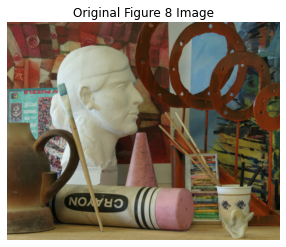

In [21]:
fig8 = cv2.imread('./images/view1.png', cv2.IMREAD_COLOR)
rgb_fig8 = cv2.cvtColor(fig8, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_fig8); plt.axis("off"); plt.title("Original Figure 8 Image");
print("Figure 8 Shape: %s" % (fig8.shape,))

In [23]:
###### FIGURE 8 ######
# 50% increase, or 120 px showing seams
# Create two lists to track pixels in seams removed (pixels_removed) and subsequent image reductions (pixels_kept).
num_pixels_to_increase = 40 # Increase image by this # of pixels
a = np.arange(0, fig8.shape[1], 1)
b = np.expand_dims(a, axis=0)
pixels_kept = np.repeat(b, fig8.shape[0], axis=0)
pixels_removed = np.zeros((fig8.shape[0],num_pixels_to_increase), dtype=int)
img = np.copy(fig8)

In [24]:
t0 = time.time()
for c in range(num_pixels_to_increase):
    # Find seam to remove
    energy_map = calc_img_energy(img)
    energy_map_forward, backtrack = calc_seam_cost_forward(energy_map)
    (min_seam, cost) = find_min_seam(energy_map_forward, backtrack)
    # Remove minimum seam from ndarray that tracks image reductions and add to list of pixels removed
    rows, cols, _ = img.shape
    mask = np.ones((rows, cols), dtype=np.bool)
    for i in range(0, rows):
        j = min_seam[i]
        mask[i, j] = False
    # Remove seam from image
    pixels_removed[:, c] = pixels_kept[mask == False].reshape((rows,))
    pixels_kept = pixels_kept[mask].reshape((rows, cols - 1))
    img = remove_seam(img, min_seam)

pixels_removed.sort(axis=1)
img = np.copy(fig8)
for c in range(num_pixels_to_increase):
    img = insert_seam(img, pixels_removed[:, c])
    pixels_removed[:, c + 1:] = pixels_removed[:, c + 1:] + 1

t1 = time.time()
total = t1-t0
print("Total Time: %d" % total)

Total Time: 28


Figure 8 Resized Shape: (370, 503, 3)


True

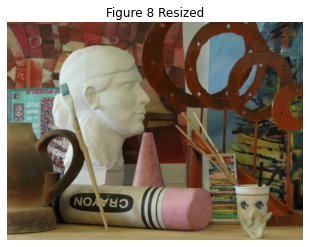

In [25]:
path = os.path.join(os.getcwd(), 'images/fig8out/')
blue, green, red = cv2.split(img)
rgb_img = np.dstack([red, green, blue])
plt.imshow(rgb_img); plt.axis("off"); plt.title("Figure 8 Resized");
print("Figure 8 Resized Shape: %s" % (rgb_img.shape,))
cv2.imwrite('%s%s.png' % (path, 'resize_1'), img)

___________________________________

In [ ]:
# Draw seams
for c in range(num_pixels_to_increase):
    img = draw_seam(img, pixels_removed[:, c])
cv2.imwrite('%s%s.png' % (path, 'resize_1_with_seams'), img)

True

In [ ]:
# 50% increase, or 120 px, on top of previous image
t0 = time.time()
fig8 = cv2.imread('./images/fig8out/resize_1.png', cv2.IMREAD_COLOR)
num_pixels_to_increase = 120 # Increase image by this # of pixels
a = np.arange(0, fig8.shape[1], 1)
b = np.expand_dims(a, axis=0)
pixels_kept = np.repeat(b, fig8.shape[0], axis=0)
pixels_removed = np.zeros((fig8.shape[0],num_pixels_to_increase), dtype=int)
img = np.copy(fig8)
for c in range(num_pixels_to_increase):
    # Find seam to remove
    energy_map = calc_img_energy(img)
    energy_map_forward, backtrack = calc_seam_cost_forward(energy_map)
    (min_seam, cost) = find_min_seam(energy_map_forward, backtrack)
    # Remove minimum seam from ndarray that tracks image reductions and add to list of pixels removed
    rows, cols, _ = img.shape
    mask = np.ones((rows, cols), dtype=np.bool)
    for i in range(0, rows):
        j = min_seam[i]
        mask[i, j] = False
    # Remove seam from image
    pixels_removed[:, c] = pixels_kept[mask == False].reshape((rows,))
    pixels_kept = pixels_kept[mask].reshape((rows, cols - 1))
    img = remove_seam(img, min_seam)
pixels_removed.sort(axis=1)
img = np.copy(fig8)
for c in range(num_pixels_to_increase):
    img = insert_seam(img, pixels_removed[:, c])
    pixels_removed[:, c + 1:] = pixels_removed[:, c + 1:] + 1
cv2.imwrite('%s%s.png' % (path, 'resize_2'), img)
t1 = time.time()
total = t1-t0
print("Total Time: %d" % total)

Total Time: 30


In [ ]:
###### Figure 7 ######
# Resize from 350 (wide) x 255 (tall) to 165 (wide) x 150 (tall)
# or 47% x 59% decrease
path = os.path.join(os.getcwd(), 'images/fig7out/')
fig7 = cv2.imread('./images/fig7.png', cv2.IMREAD_COLOR)

In [ ]:
# Populate transport map
t0 = time.time()
r = 105 # no. of rows to reduce
c = 185 # no. or cols to reduce
t_map = np.zeros((r + 1, c + 1), dtype='float32')
t_map_choice = np.zeros((r + 1, c + 1), dtype=np.uint8) # 1 will signify horizontal; 0 will signify vertical
# Fill out first column which is removing horizontal seams (r)
img = np.copy(fig7)
image_cache = {}
for i in range(1, r + 1):
    (img, cost) = remove_horizontal_seam(img)
    image_cache["%d_%d" % (i, 0)] = img
    t_map[i,0] = t_map[i-1,0] + cost
    t_map_choice[i,0] = 1

# Fill out first row caching the image in memory
img = np.copy(fig7)
for i in range(1, c + 1):
    (img, cost) = remove_vertical_seam(img)
    image_cache["%d_%d" % (0, i)] = img
    t_map[0,i] = t_map[0,i-1] + cost
    t_map_choice[0,i] = 0

# Fill out remaining rows
for i in range(1, r + 1): # rows
    for j in range(1, c + 1): # cols
        # Try removing a horizontal seam by choosing a top neighbor
        img = image_cache["%d_%d" % (i-1, j)]
        (horizontal_img, cost) = remove_horizontal_seam(img)
        horizontal_cost = t_map[i-1,j] + cost
        
        # Try removing a vertical seam by choosing a left neighbor
        img = image_cache["%d_%d" % (i, j-1)]
        (vertical_img, cost) = remove_vertical_seam(img)
        vertical_cost = t_map[i,j-1] + cost
        
        if horizontal_cost < vertical_cost:
            t_map_choice[i,j] = 1
            t_map[i,j] = horizontal_cost
            image_cache["%d_%d" % (i, j)] = horizontal_img
        else:
            t_map_choice[i,j] = 0
            t_map[i,j] = vertical_cost
            image_cache["%d_%d" % (i, j)] = vertical_img

t1 = time.time()
total = t1-t0
print("Total Time: %d" % total)

In [ ]:
normalized_t_map = (255 - 0) / (np.max(t_map) - np.min(t_map)) * (t_map - np.min(t_map)) + 0
normalized_t_map = normalized_t_map.astype('uint8')
converted_t_map = cv2.cvtColor(normalized_t_map, cv2.COLOR_GRAY2BGR)
cv2.imwrite('%sconverted_t_map.png' % (path), t_map_color_map)
t_map_color_map = cv2.applyColorMap(converted_t_map, cv2.COLORMAP_JET)
cv2.imwrite('%st_map_color.png' % (path), t_map_color_map)

True

In [ ]:
# Output final image
cv2.imwrite('%s%s.png' % (path, 'fig7_resized'), image_cache["%d_%d" % (r, c)])

True

In [ ]:
# Output transport map with path
# Try removing a horizontal seam by choosing a top neighbor (1)
# Try removing a vertical seam by choosing a left neighbor (0)
seam = np.zeros((t_map_color_map.shape[0], t_map_color_map.shape[1]), dtype=np.bool)
i, j = r, c
while not (i == 0 and j == 0):
    seam[i, j] = True
    action = t_map_choice[i, j]
    if action > 0:
        i -= 1
    else:
        j -= 1
seam[i, j] = True

In [ ]:
blue, green, red = cv2.split(t_map_color_map)
for i in range(t_map_color_map.shape[0]):
    for j in range(t_map_color_map.shape[1]):
        if seam[i, j]:
            blue[i, j] = 255
            green[i, j] = 255
            red[i, j] = 255
img_with_seam = np.zeros((blue.shape[0], blue.shape[1], 3))
img_with_seam[:,:,0] = blue
img_with_seam[:,:,1] = green
img_with_seam[:,:,2] = red

In [ ]:
cv2.imwrite('%st_map_color_w_seam.png' % (path), img_with_seam)

True

In [ ]:
# Save transport map to file
np.savetxt('%stransport_map.txt' % (path), t_map, newline="\n")